## Mount the google drive for downloading and storing dataset. 

In [ ]:
# import all libraries
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load # for saving and loading model
import time
from sklearn import metrics
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Make a directory "MalwareDataset" in the google drive to store the dataset downloaded from CICDataset.

In [ ]:
!mkdir drive/MyDrive/MalwareDataset/


In [ ]:
!curl http://205.174.165.80/CICDataset/CICMalAnal2017/Dataset/APKs/Benign-APKs-2017.zip -o drive/MyDrive/MalwareDataset/Benign-APKs-2017.zip
!curl http://205.174.165.80/CICDataset/CICMalAnal2017/Dataset/APKs/Adware-APKs.zip -o drive/MyDrive/MalwareDataset/Adware-APKs.zip
!curl http://205.174.165.80/CICDataset/CICMalAnal2017/Dataset/APKs/Ransomware-APKs.zip -o drive/MyDrive/MalwareDataset/Ransomware-APKs.zip
!curl http://205.174.165.80/CICDataset/CICMalAnal2017/Dataset/APKs/SMSmalware-APKs.zip -o drive/MyDrive/MalwareDataset/SMSmalware-APKs.zip 
!curl http://205.174.165.80/CICDataset/CICMalAnal2017/Dataset/APKs/Scareware-APKs.zip -o drive/MyDrive/MalwareDataset/Scareware-APKs.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6892M  100 6892M    0     0  8201k      0  0:14:20  0:14:20 --:--:--  669k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  720M  100  720M    0     0  3136k      0  0:03:55  0:03:55 --:--:-- 18.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99.9M  100 99.9M    0     0  1643k      0  0:01:02  0:01:02 --:--:-- 2258k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181M  100  181M    0     0   756k      0  0:04:05  0:04:05 --:--:-- 6143k
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
!unzip -o drive/MyDrive/MalwareDataset/Benign-APKs-2017.zip -d drive/MyDrive/MalwareDataset
!unzip -o drive/MyDrive/MalwareDataset/Adware-APKs.zip -d drive/MyDrive/MalwareDataset/
!unzip -o drive/MyDrive/MalwareDataset/Ransomware-APKs.zip -d drive/MyDrive/MalwareDataset/
!unzip -o drive/MyDrive/MalwareDataset/SMSmalware-APKs.zip -d drive/MyDrive/MalwareDataset/
!unzip -o drive/MyDrive/MalwareDataset/Scareware-APKs.zip  -d drive/MyDrive/MalwareDataset/

Archive:  drive/MyDrive/MalwareDataset/Benign-APKs-2017.zip
   creating: drive/MyDrive/MalwareDataset/Benign_2017/
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.acmeaom.android.myradar.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.aceviral.smashycity.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.acer.ccd.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.ace.securityplus.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.ac.photo.frames.valentines.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.abbyy.mobile.lingvo.market.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.abaenglish.videoclass.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.aadhk.woinvoice.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.aadhk.time.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.aadhk.restpos.apk  
  inflating: drive/MyDrive/MalwareDataset/Benign_2017/com.

# Collect static information from APK files as features representing android Apps. Static information include information from AndroidManifest.xml and Dex files. 

In [ ]:
#install static analysis tool
!pip install androguard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 922 kB 9.8 MB/s 
     |████████████████████████████████| 105 kB 61.3 MB/s 
     |████████████████████████████████| 1.6 MB 41.7 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
from androguard.core.bytecodes import apk, dvm
from androguard.core.analysis import analysis
import os
import pandas as pd
import numpy as np

In [ ]:
#list for storing permission, activities and package used by the android apps obtained from static analysis
permission_list=[] 
activity_list=[]
package_list = []

#save app where errors occur, if any
error_list_permission=[]
error_list_package=[]
error_list_activity=[]

#save the name of the corresponding apk file
apkname_list=[] 

## Use the androguard tool for extracting static information

In [ ]:
# obtain information on permission requested by APK
def get_permissions(path):
  try:
    app = apk.APK(path)
    permission = app.get_permissions()
    apkname_list.append(path.split("/")[-1]) #save the app name
    permission_list.append(permission) #save permission
    print(permission)
  except Exception as ex:
    print(ex)
    error_list_permission.append(path.split("/")[-1])

# obtain information on package requested by APK
def get_package(path):
  try:
    app = apk.APK(path)
    package = app.get_package()
    apkname_list.append(path.split("/")[-1]) #save the app name
    package_list.append(package) #save package 
    print(package)
  except Exception as ex:
    print(ex)
    error_list_package.append(path.split("/")[-1])

# obtain information on activities requested by APK
def get_activity(path):
  try:
    app = apk.APK(path)
    activities=app.get_main_activities()
    apkname_list.append(path.split("/")[-1]) #save the app name 
    activity_list.append(activities)
    print(activities)
  except Exception as ex:
    print(ex)
    error_list_activity.append(path.split("/")[-1])

In [ ]:
# save the package information of all apps in a folder to a csv file
def get_package_group(folder, save_dir):
  for root, dirs, files in os.walk(folder, topdown=False):
    for name in files:
      path = os.path.join(root, name)
      get_package(path)
      
  print("package len: ", len(package_list))
  print("apkname len: ", len(apkname_list))

  data_frame = pd.DataFrame(package_list).T
  data_frame.columns = apkname_list
  print(data_frame)
  data_frame.to_csv(save_dir, index=False)

In [ ]:
# save the activity information of all apps in a folder to a csv file
def get_activity_group(folder, save_dir):
  for root, dirs, files in os.walk(folder, topdown=False):
    for name in files:
      path = os.path.join(root, name)
      get_activity(path)
      
  print("package len: ", len(activity_list))
  print("apkname len: ", len(apkname_list))

  data_frame = pd.DataFrame(activity_list).T
  data_frame.columns = apkname_list
  print(data_frame)
  data_frame.to_csv(save_dir, index=False)

In [ ]:
# save the permission information of all apps in a folder to a csv file
def get_permissions_group(folder, save_dir):
  for root, dirs, files in os.walk(folder, topdown=False):
    for name in files:
      path = os.path.join(root, name)
      get_permissions(path)
      
  print("permission len: ", len(permission_list))
  print("apkname len: ", len(apkname_list))

  data_frame = pd.DataFrame(permission_list).T
  data_frame.columns = apkname_list
  print(data_frame)
  data_frame.to_csv(save_dir, index=False)

In [ ]:
#make a directory for storing csv_data
!mkdir drive/MyDrive/MalwareDataset/csv_data/

In [ ]:
# get permissions from folder Benign apps. Save it on a new folder csv_data 

apkname_list = []
permission_list = []
get_permissions_group("/content/drive/MyDrive/MalwareDataset/Benign_2017/", "/content/drive/MyDrive/MalwareDataset/csv_data/Benign_2017_permission.csv")

['com.android.vending.BILLING', 'android.permission.ACCESS_MOCK_LOCATION', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'com.acmeaom.android.myradar.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'com.android.vending.BLUETOOTH_ADMIN', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.android.vending.BLUETOOTH']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WRITE_MEDIA_STORAGE', 'android.permission.READ_PROFILE', 'android.permission.INTERNET', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_LOGS', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.acer.aop.permi

['com.android.vending.BILLING', 'android.permission.READ_PROFILE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.CAMERA', 'cm.confide.android.permission.C2D_MESSAGE', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.RECORD_AUDIO', 'android.permission.GET_ACCOUNTS']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.BROADCAST_STICKY', 'android.permission.SET_WALLPAPER']
['android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'com.amazon.device.messaging.permission.RECEIVE', 'com.sec.android.provider.badge.permission.READ', 'br.com.escolhatecnologia.vozdonarrador.permission.C2D_MESSAGE', 'com.android.vending.BILLING', 'com.htc.launcher.permission.READ_SETTINGS', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'com.sec.android.provider.badge.permission.WRITE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.anddoes.launcher.permission.UPDATE_COUNT', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'com.sonyericsson.home.permission.BROADCAST_BADGE', 'com.google.android.c2dm.permission.RECEIVE', 'com.htc.launcher.permission.UPDATE_SHORTCUT', 'com.majeur.launcher.permission.UPDATE_BADGE', 'android.permission.MODIFY_AUDIO_SETTINGS']
['com.android.vending.BILLING', 'android.permission.WAKE_LOCK', 'android.permission.READ_SMS', 'android.permission.REA

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.INTERNET', 'android.permission.CAMERA', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.ACCESS_NETWORK_STATE', 'au.com.tapstyle.permission.C2D_MESSAGE', 'android.permission.SEND_SMS', 'android.permission.WRITE_CALENDAR', 'android.permission.READ_CALENDAR', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.USE_CREDENTIALS', 'android.permission.BLUETOOTH', 'android.permission.READ_CONTACTS', 'android.permission.GET_ACCOUNTS']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'au.com.angr

['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_WIFI_STATE', 'air.com.launchday.mobile.rocketleague.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.GET_ACCOUNTS']
['com.android.vending.BILLING', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.DISABLE_KEYGUARD']
['com.android.vending.BILLING', 'android.permission.CAMERA', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.INTERNET']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.perm

['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_NETWORK_STATE', 'com.applicaster.babytv.vod.permission.C2D_MESSAGE', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.GET_ACCOUNTS', 'com.applicaster.permission.C2D_MESSAGE']
['android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.CHECK_LICENSE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'com.ap

['com.app.sporttvlive.permission.C2D_MESSAGE', 'com.anddoes.launcher.permission.UPDATE_COUNT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.VIBRATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.WAKE_LOCK', 'com.htc.launcher.permission.READ_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'com.htc.launcher.permission.UPDATE_SHORTCUT', 'android.permission.INTERNET', 'com.sonyericsson.home.permission.BROADCAST_BADGE', 'com.majeur.launcher.permission.UPDATE_BADGE', 'com.sec.android.provider.badge.permission.READ', 'com.sec.android.provider.badge.permission.WRITE', 'android.permission.RECEIVE_BOOT_COMPLETED']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.SET_WALLPAPER']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.REA

['com.airasia.mobile.gcm.permission.C2D_MESSAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.USE_CREDENTIALS', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CAMERA', 'android.permission.READ_PHONE_STATE', 'android.permission.WRITE_CALENDAR', 'android.permission.GET_ACCOUNTS', 'android.permission.READ_CALENDAR']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.RECEIVE_BOOT_COMPLETED']
['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.RECORD_AUDIO', '

['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'com.active.aps.meetmobile.permission.C2D_MESSAGE', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.SEND_SMS', 'android.permission.GET_ACCOUNTS']
['android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_CORSE_LOCATION', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'com.depadstudio.sugardaddy.PAYMENT_BROADCAST_PERMISSION', 'android.permission.READ_PHONE_STATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'andr

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.INTERNET', 'android.permission.RESTART_PACKAGES', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.DISABLE_KEYGUARD', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.RECORD_AUDIO', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.DOWNLOAD_WITHOUT_NOTIFICATION', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'android.permission.WRITE_SETTINGS', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.MANAGE_ACCOUNTS', 'android.permission.GET_TASKS', 'android.permission.READ_LOGS', 'android.permission.GET_ACCOUNTS', 'android.permission.CHANGE_WIFI_STATE']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.per

['com.bizzabo.client.permission.MAPS_RECEIVE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_COARSE_LOCATION', 'com.bizzabo.client.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.READ_CALENDAR', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CAMERA', 'android.permission.READ_CONTACTS', 'android.permission.GET_TASKS', 'com.google.android.providers.gsf.permission.READ_GSERVICES', 'android.permission.GET_ACCOUNTS', 'android.permission.WRITE_CALENDAR']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.BLUETOOTH', 'android.permission.INTERNET', 'android.permission

['com.android.vending.BILLING', 'android.permission.FLAG_GRANT_READ_URI_PERMISSION', 'com.android.email.permission.READ_ATTACHMENT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.WRITE_INTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'com.insyncapp.diabete.permission.C2D_MESSAGE', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.READ_INTERNAL_STORAGE', 'android.permission.READ_CALENDAR']
['com.google.android.c2dm.permission.RECEIVE', 'android.permission.WAKE_LOCK', 'com.instantgaming.android.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STO

['com.google.android.c2dm.permission.RECEIVE', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'com.amazon.device.messaging.permission.RECEIVE', 'android.permission.ACCESS_NETWORK_STATE', 'com.gohopscotch.android.saskrush.permission.UA_DATA', 'android.permission.ACCESS_FINE_LOCATION', 'com.gohopscotch.android.saskrush.permission.C2D_MESSAGE', 'android.permission.INTERNET', 'android.permission.BLUETOOTH', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.CAMERA', 'com.gohopscotch.android.saskrush.permission.RECEIVE_ADM_MESSAGE', 'android.permission.GET_TASKS', 'android.permission.GET_ACCOUNTS']
['android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'com.godpeople.GPto

In [ ]:
# get activity from folder Benign apps. Save it on a new folder csv_data 

apkname_list = []
activity_list = []
get_activity_group("/content/drive/MyDrive/MalwareDataset/Benign_2017/", "/content/drive/MyDrive/MalwareDataset/csv_data/Benign_2017_activity.csv")

{'com.acmeaom.android.myradar.app.activity.MyRadarActivity'}
{'com.aceviral.smashycity.UnityPlayerNativeActivity'}
{'com.acer.ccd.ui.MainEntranceActivity'}
{'com.ace.securityplus.SplashScreenActivity'}
{'com.ac.photo.frames.valentines.Splash_valentines'}
{'com.abbyy.mobile.lingvo.SplashActivity'}
{'com.abaenglish.videoclass.SplashActivity'}
{'com.aadhk.woinvoice.SplashActivity'}
{'.MainActivity'}
{'com.aadhk.restpos.LoginActivity'}
{'com.Whatscan.forWhatstab.Online'}
{'MainActivity'}
{'com.NaimDev.SnapPhotoFilters.SplashActivity'}
{'com.Mp3FreeMusic.Mp3FreeMusicMusicMp3.SplashActivity'}
{'com.unity3d.player.UnityPlayerActivity'}
{'com.MegaMemeProductions.MEMESoundBoard.RunnerActivity'}
{'org.cocos2dx.cpp.AppActivity'}
{'com.start.aplication.template.MainActivity'}
{'.Dashboard_000'}
{'com.unity3d.player.UnityPlayerActivity'}
{'com.kineware.megasplash.MegaSplashUnityPlayerActivity'}
{'com.greetingCardsTEST.MainActivity'}
{'com.Best.guidecandycrushsodasaga.SplashScreen'}
{'md540df0684bab

set()
{'me.chumob.camera.activities.MainActivity'}
{'ch.protonmail.android.activities.SplashActivity'}
{'cgeo.geocaching.MainActivity'}
{'cc.pacer.androidapp.ui.splash.SplashActivity'}
{'cc.dreamspark.intervaltimer.MainActivity'}
{'call.harley.quinn.MainActivity'}
{'ca.windmobile.selfcare.prod.MainActivity'}
{'net.bodas.launcher.views.activities.MainActivity', 'net.bodas.launcher.views.activities.SplashScreen'}
{'com.digiflare.tsn.activities.SplashActivity'}
{'.SaveCaActivity'}
{'com.purpleforge.pfclient.SplashActivity'}
{'ca.markham.accessmarkham.AccessMarkham'}
{'ca.manulife.android.MainActivity'}
{'ca.lapresse.android.lapressemobile.StartupActivity'}
{'ca.insuranceinstitute.iicmobile.ui.activity.SplashActivity'}
{'ca.indigo.HomeActivity'}
{'.ApplicationTemplate'}
{'com.dominos.activities.InitialLaunchActivity'}
{'ca.crea.realtor.activities.LoadingActivity'}
{'com.north.expressnews.WelcomeActivity'}
{'com.wifylgood.scolarit.coba.activity.SplashscreenActivity'}
{'com.capitalone.mobile

{'br.com.escolhatecnologia.vozdonarrador.MainActivity'}
{'bpst.met.sharinganlockscreen.Prefferences'}
{'biz.bookdesign.librivox.LibriVoxActivity'}
{'com.meevii.bibleverse.splash.SplashActivity'}
{'bible.bibleverse.biblia.bibleverses.scripture.holywrit.verse.devotion.base.ac.WelcomeActivity'}
{'bible.bibleverse.bibleverses.biblia.holywrit.scripture.verse.devotion.base.ac.WelcomeActivity'}
{'berkah25com.guideforroblox.guideforroblox.Splash'}
{'bbc.mobile.news.v3.app.TopLevelActivity'}
{'basic.guru.gforms.LoginActivity'}
{'baby.com.kidsToysReview.Logo'}
{'baby.com.ToysToSee.Logo'}
{'baby.com.SurpriseCollector.Logo'}
{'baby.com.KidsandToys.Logo'}
{'baby.com.KidsSurpriseFun.Logo'}
{'baby.com.Kiddyzuzaa.Logo'}
{'baby.com.FunToyzCollector.Logo'}
{'baby.com.DisneyCarToys.Logo'}
{'baby.com.CrazyFunKids.Logo'}
{'baby.com.CKNToys.Logo'}
{'baby.com.BabyBigMouth.Logo'}
{'aviaseller.su.SplashScreen'}


{'au.com.tapstyle.activity.MenuActivity'}
{'.WikiCamps'}
{'.MainActivity'}
{'apptrends.love_photo_frames_hd_and_love_greetings.love_couple_photo_collage.MainActivity'}
{'app.zenly.locator.ui.activities.RouterActivity'}
{'app.qrcode.MainActivity'}
{'app.medicalid.activities.LauncherActivity'}
{'aplicacion.tiempo.InicialActivity'}
{'.AnxietySymptoms_Treatment'}
{'anton.kets.despicableme.WelcomeActivity'}
{'andrewgilman.dartsscoreboard.DartsScoreboard'}
{'com.example.app.MainActivity'}
{'ak.alizandro.smartaudiobookplayer.PlayerActivity'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'air.com.trailmapps.AND.SplashScreen'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'com.playtika.Slotomania'}
{'.AppEntry'}


{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'.AppEntry'}
{'a.envisionmobile.caa.Launch'}
{'com.atistudios.mondly.languages.MainActivity'}
{'com.atistudios.mondly.languages.MainActivity'}
{'com.athan.activity.AthanSplashActivity'}
{'.main'}
{'com.asurion.android.common.ui.v1.activity.ZeroActivity'}
{'com.astroid.yodha.activity.SplashActivity'}
{'com.astroid.yodha.activity.SplashActivity'}
{'com.astone.manhairstyle.editor.SplashScreenActivity'}
{'com.asos.app.ui.activities.ConfigActivity'}
{'com.itonline.anastasiadate.activities.AnastasiaDateLaunchActivity'}
{'com.asiainno.uplive.init.splash.SplashActivity'}
{'com.asd.gymapp.SplashScreen'}
{'com.arsenal.geosuper.MainActivity'}
{'com.arrowshapes.lockscreen.MainMenu'}
{'com.arbimobi.recipes.SplashActivity'}
{'com.areyouinterested.android.MainActivity'}
{'org.cocos2dx.lua.AppActivity'}
{'com.ta3arof.MainActivity'}
{'com.aqreadd.lw.valentines.gle.WelcomeActivi

{'com.applicaster.babytv.vod.activities.IntroActivity'}
{'com.applepie4.mylittlepet.ui.main.MainActivity'}
{'com.mediamushroom.copymydata.ui.PageViewActivity'}
{'com.appcom.lecampeur.feature.MainMenuActivity'}
{'com.appcom.hikster.feature.map.MapActivity'}
{'com.appscreat.project.activity.ActivityLoading'}
{'com.app2game.romantic.photo.frames.activity.MainActivity'}


{'com.app.androidlivetv.SplashActivity'}
{'com.app.my.dream.valentinesdaycards.SplashActivity'}
{'com.snappy.appypie.HomeActivity'}
{'com.app.guidelenses.activity1'}
{'com.snappy.appypie.HomeActivity'}
{'.DocumentMenuActivity'}
{'com.ansca.corona.CoronaActivity'}
{'com.apalon.ringtones.adconfig.AdConfigActivity'}
{'com.apalon.optimizer.activity.FastBoostActivity'}
{'com.ittus.book_template.SplashScreenActivity'}
{'com.ittus.book_template.SplashScreenActivity'}
{'com.aos.clean.security.android.boost.activity.GuideActivity'}
{'com.more.setting.KeyboardSettingsActivity'}
{'com.anydo.activity.SplashActivity'}
{'com.anvilgard.moonknight.StartupActivity'}
{'com.antutu.ABenchMark.ABenchMarkStart'}
{'com.antivirus.ui.main.AntivirusMainScreen'}
{'com.antakiojuice.fremleckatapp.MainActivity'}
{'com.aniapps.shortstories.MainActivity'}
{'com.anghami.activities.SplashActivity_'}
{'com.andymstone.metronome.MetronomeBeatsActivity'}
{'com.andrwq.recorder.RecorderActivity'}
{'.Dashboard_000'}
{'.Dashbo

set()
{'com.agus.cnd.calendar.MainActivity'}


{'com.afl.psychicslive.view.PsychicsLiveView'}
{'com.afkettler.earth.LauncherActivity'}
{'com.aerilys.acr.android.MainActivity_'}
{'com.adultswim.apps.ott.MainController'}
{'com.adpog.diary.activity.SplashActivity'}
{'com.adobe.reader.AdobeReader'}
{'.AdobeAIRMainActivity'}
set()
{'com.adhoclabs.burner.LoadingActivity'}
{'com.adamrocker.android.input.simeji.theme.template.SplashActivity'}
{'com.adamapps.tipsforsupermario.guide.SplashScreen'}
{'com.adamapps.tipsforspidermangames.SplashScreen'}
{'com.actualsoftware.faxfile.activity.FaxFileActivity'}
{'com.actmobile.dashvpn.SplashActivity'}


{'com.active.aps.meetmobile.activities.SplashActivity'}
{'com.depadstudio.sugardaddy.AppActivity'}
{'com.delco.courier.activities.SplashActivity'}
{'com.dashlane.ui.activities.BrowserLauncherDispatcher', 'com.dashlane.ui.activities.SplashScreen'}
{'com.dannyconnell.android.fudget.MainActivity'}


{'com.ddianle.activity.MainActivity'}
{'com.css.selfhealing.Home'}
{'com.cruiseinfotech.sixpackphotoeditor.MainActivity'}
{'com.disneyfr.DisneyFRBootActivity'}
{'com.cool.raftsurvival.MainActivity'}
{'com.conard.nerosinfernoslots.SplashActivity'}
{'com.code_breaker.RubikCubeSolver2x2.Home'}
{'com.cmplay.AppActivity'}
{'com.cmcm.locker.theme.ThemeActivity'}
{'com.clusor.ice.ICECardActivity'}
{'com.biowink.clue.activity.WheelActivity_Launcher'}
{'com.cloudmosa.app.LemonActivity'}
{'com.clickapps.offline.english.dictionary.HomeActivity'}
{'com.cleevio.spendee.ui.MainActivity'}
{'.LoadActivity'}
{'.LoadActivity'}
{'ks.cm.antivirus.main.SplashActivity'}
{'com.keniu.security.main.MainActivity'}
{'com.clean.security.memory.booster.battery.activity.GuideActivity'}
{'com.zenjoy.freemusic.main.view.MainActivity'}
{'com.classdojo.android.ClassDojoActivity'}
{'com.clashofclans.gemscoc.Activity.SplashScreenActivity'}
{'com.cibc.base.android.mobi.activity.MainActivity'}
{'com.chineseskill.lan_tool.s

{'com.bizzabo.client.ui.activities.IntroductionActivity'}
{'com.esocialllc.triplog.module.main.MainActivity'}
{'com.bitwize10.supersimpleshoppinglist.MainActivity'}
{'com.bitsmedia.android.muslimpro.activities.SplashActivity'}
{'com.bitmisrow.legoninjagorebooted.WelcomeScreen'}
{'com.bitmisrow.legobatman.WelcomeScreen'}
{'com.bitdefender.security.material.DashboardActivity'}
{'com.bigfishgames.ll2.AppExpansionDownloaderActivity'}
{'com.bigduckgames.flow.flow'}
{'com.bigapps.xperror.MainActivity'}
{'com.bidgely.mobile.energyfit.MainActivity'}
{'com.bible.kids.BibleJunior'}
{'com.bf.app7418de.MainActivity'}
{'com.bestweatherfor.bibleoffline_pt_ra.bibleoffline.splash.Splash'}
{'com.berrybongobrother.donaldtrumpsoundboard.MainActivity'}
{'com.beautyapps.makeup.beauty.photo.effects.Splash_Activity'}
{'com.beakerapps.instameter2.LogInActivity'}
{'de.cominto.haxe.android.splash.SplashActivity'}
{'com.barchart.app.activities.SplashActivity'}
{'com.bamnetworks.mobile.android.ballpark.onboard.ac

{'com.intsig.camcard.salesforce.activity.SplashActivity'}
{'com.insyncapp.diabete.act.SplashActivity'}
{'com.instantgaming.android.Activities.SplashActivity'}
{'com.inigoapp.inigoandroid.SplashScreenActivity'}
{'com.imobilize.ultimateHypnosisGH.activity.SplashActivity'}
{'com.immediate.imcreader.MainActivity'}
{'com.immediate.imcreader.MainActivity'}
{'com.immediate.imcreader.MainActivity'}
{'com.ilixa.ebp.ui.MainActivity'}
{'com.qisi.plugin.activities.SplashActivity'}
{'com.qisi.plugin.activities.SplashActivity'}
{'com.iherb.ChooseCountryActivity'}
{'com.iggnovation.offhck.MainActivity'}
{'com.idmiranappss.phoneringtones2016.mobileringtones.SplashActivity'}
{'com.hsbc.activities.LaunchActivity'}
{'com.htgames.animesama.activity.WelcomeActivity'}
{'com.hoteltonight.android.prod.activity.SplashActivity'}
{'com.hmobile.frenchbible.SplashActivity'}
{'com.born2play.solitaire.theme.MainActivity'}
{'com.kunkunn.photogridbuilder.MainActivity'}
{'com.tagged.activity.LaunchActivity'}
{'com.hell

{'com.wilshireaxon.android.core.activity.StartupActivity'}
{'com.godpeople.GPtong.ETC.SplashActivity'}
{'com.google.android.vending.expansion.downloader_impl.DownloaderActivity'}
{'com.globalinto.legoninjagoshadow.activities.ActivitySplash'}
{'com.globalegrow.app.gearbest.SplashActivity'}
{'com.gentoozero.memecreator.MainActivity'}
{'com.geniatech.nettv.StartpageActivity'}
{'com.gau.go.weatherex.framework.RecommendWeatherEx'}
{'com.gameloft.android.ANMP.GloftPOHM.MainActivity'}
{'.Start'}
{'com.funny.whosdaddy.MainActivity'}
{'com.funnyfacemaker.MainScreen'}
{'com.polaris.moviesonline.activity.SplashActivity'}
{'com.life360.android.shared.base.LauncherActivity'}
{'com.freshgrade.StudentApp.MainActivity'}
{'com.freewaiter.redbarn.MainActivity'}
{'.AppEntry'}
{'com.freegame.simulatorfnafsljumpscare.SplashActivity'}
{'com.mdrs.sms_over_xmpp.ui.SplashActivity'}
{'com.flyersoft.moonreader.ActivityMain'}
{'com.fivetouchsolutions.emcmba2017.MainActivity'}
{'com.finperssaver.vers2.ui.settings2

In [ ]:
# get package from folder Benign apps. Save it on a new folder csv_data 

apkname_list = []
package_list = []
get_package_group("/content/drive/MyDrive/MalwareDataset/Benign_2017/", "/content/drive/MyDrive/MalwareDataset/csv_data/Benign_2017_package.csv")

com.acmeaom.android.myradar
com.aceviral.smashycity
com.acer.ccd
com.ace.securityplus
com.ac.photo.frames.valentines
com.abbyy.mobile.lingvo.market
com.abaenglish.videoclass
com.aadhk.woinvoice
com.aadhk.time
com.aadhk.restpos
com.Whatscan.forWhatstab
com.ShakeMe.shake
com.NaimDev.SnapPhotoFilters
com.Mp3FreeMusic.Mp3FreeMusicMusicMp3
com.MobileSportsTime.MiniGolfEldoradoGolfCourse
com.MegaMemeProductions.MEMESoundBoard
com.MMMonsterMaster.pandaBubbleShooter.free
com.MJ.Old.Face.Aging.Booth.Funny.App
com.HelloNeighbor.roblox
com.GeorgeBeaumont.TrickyShot
com.ElfizMedia.Djdubstepmscmkrpd
com.CicmilicValentinesDayCards
com.Best.guidecandycrushsodasaga
com.ArbiterSports.ArbiterSports
com.AquariumLiveWallpapernn
com.AngleApp.ValentinesMessages
com.AngleApp.HappyValentinesWishes
com.AngleApp.HappyValentineDayWish
codematics.universal.tv.remote.control
co.ifwe.hi5.live
co.gotitapp.android
co.bitx.android.wallet
cn.xiaochuankeji.tieba
cn.wps.moffice_eng
cmsecurity.applock.theme.valentineshear

cm.confide.android
chumob.valentine.photo.frames
ch.protonmail.android
cgeo.geocaching
cc.pacer.androidapp
cc.dreamspark.intervaltimer
call.harley.quinn
ca.windmobile.selfcare.prod
ca.weddingwire.launcher
ca.tsn.mobile.android
ca.save.m
ca.mississauga.roads
ca.markham.accessmarkham
ca.manulife.android
ca.lapresse.android.lapressemobile
ca.insuranceinstitute.iicmobile
ca.indigo
ca.geoactivity.geoactivityrigs.MobilePro
ca.dominospizza
ca.crea.realtor
ca.com.dealmoon.android
ca.coba.scolarit.lionelgroulx
ca.capitalone.enterprisemobilebanking
ca.cahrc_ccrha.cyff
ca.blood.giveblood
ca.bellmedia.cravetv
ca.autotrader.userapp
business.card.maker.scopic
browser.flowers2
br.gov.caixa.fgts.trabalhador
br.com.tapps.myderp
br.com.ridsoftware.shoppinglist
br.com.gerenciadorfinanceiro.controller


br.com.escolhatecnologia.vozdonarrador
bpst.met.sharinganlockscreen
biz.bookdesign.librivox
bibleverses.bibleverse.bible.biblia.verse.devotion
bible.bibleverse.biblia.bibleverses.scripture.holywrit.verse.devotion
bible.bibleverse.bibleverses.biblia.holywrit.scripture.verse.devotion
berkah25com.guideforroblox.guideforroblox
bbc.mobile.news.ww
basic.guru.gforms
baby.com.kidsToysReview
baby.com.ToysToSee
baby.com.SurpriseCollector
baby.com.KidsandToys
baby.com.KidsSurpriseFun
baby.com.Kiddyzuzaa
baby.com.FunToyzCollector
baby.com.DisneyCarToys
baby.com.CrazyFunKids
baby.com.CKNToys
baby.com.BabyBigMouth
aviaseller.su


au.com.tapstyle
au.com.angryrobot.wikicamps
at.reebekili.fbutton
apptrends.love_photo_frames_hd_and_love_greetings
app.zenly.locator
app.qrcode
app.medicalid.free
aplicacion.tiempo
anxiety.symptoms.treatment
anton.kets.despicableme
andrewgilman.dartsscoreboard
ali.coupon.code.sale.all
ak.alizandro.smartaudiobookplayer
air.uk.co.bbc.android.mediaplayer
air.u.live.video.chat
air.nn.mobile.app.main
air.im.phantom.earthquakes
air.com.yudu.ReaderAIR2902554
air.com.trailmapps.AND.skypilot
air.com.starfall.more
air.com.screenpapermedia.basic.mobile.launchday.nba2k15
air.com.rosettastone.mobile.CoursePlayer
air.com.playtika.slotomania
air.com.nextlot.mobile.webcast.sekura


air.com.launchday.mobile.rocketleague
air.com.indiegoes.archangelmichael
air.com.hypah.io.slither
air.com.gamebrain.hocus
air.com.ercangigi.sitesin3d
air.com.articulate.articulatemobileplayer
air.com.adobe.connectpro
air.G2JValentineRoseEscape2017
air.G2JSmallBoyFactoryEscape3
air.G2JCuteBoySwimmingEscape
a.envisionmobile.caa
com.atistudios.italk.ar
com.atistudios.ispeak.fr
com.athan
com.at.meme.maker
com.asurion.android.wm.mobilesecurity
com.astroid.yodha.pro
com.astroid.yodha
com.astone.manhairstyle.editor
com.asos.app
com.asiandate
com.asiainno.uplive
com.asdhillon.admin.gymapplication
com.arsenal.geosuper
com.arrowshapes.cat.pattern.screen.lock
com.armobi.recipes
com.areyouinterested.android
com.arcadegame.games.bingo.holiday.free.slots.bash
com.arabe.banatchat.mobachircamera
com.aqreadd.lw.valentines.gle.lite
com.apusapps.launcher
com.apstoide
com.appzess.valentinedayphotoframes
com.appyown.valentinephotoframes
com.appxy.pocketexpense
com.appturbo.appoftheday2015
com.apptoide.free

com.applicaster.babytv.vod
com.applepie4.mylittlepet.en
com.apple.movetoios
com.appcom.lecampeur
com.appcom.hikster
com.appblockgames.freecraftexploration
com.app2game.romantic.photo.frames


com.app.sporttvlive
com.app.my.dream.valentinesdaycards
com.app.kitchenjukebox
com.app.guidelenses
com.app.familytv
com.app.copticreader
com.apexmobilegames.smashblaster
com.apalon.ringtones
com.apalon.optimizer
com.ap.lhc
com.ap.leb
com.aos.clean.security.android.boost
com.aoemoji.keyboard
com.anydo
com.anvilgard.moonknight
com.antutu.ABenchMark
com.antivirus
com.antakiojuice.fremleckatapp
com.aniapps.shortstories
com.anghami
com.andymstone.metronome
com.andrwq.recorder
com.andromo.dev565496.app554379
com.andromo.dev540217.app558305
com.andromo.dev430081.app392812
com.andromo.dev281819.app407963
com.androidrocker.callblocker
com.androidaplicativos.phonetrackerbynumber
com.androdiki.flygpsplus
com.andrewtretiakov.followers_assistant
com.anddoes.launcher
com.ancestry.android.apps.ancestry
com.amorFrases
com.aminlogic.NavigationCompass
com.amikulich.babysleep
com.amdroidalarmclock.amdroid
com.amctv.thewalkingdead.deadyourself
com.amble43.MemeBroker
com.amazon.sellermobile.android
com.ama

com.airasia.mobile
com.agus.cnd.calendar


com.afl.psychicslive.view
com.afkettler.earth
com.aerilys.acr.android
com.adultswim.apps.now
com.adpog.diary
com.adobe.reader
com.adobe.air
com.adi.dev.java.android.wallpaper.live.analogclock
com.adhoclabs.burner
com.adamrocker.android.input.simeji.global.sticker.ugh.top
com.adamapps.tipsforsupermario.guide
com.adamapps.tipsforspidermangames
com.actualsoftware.faxfile
com.actmobile.dashvpn


com.active.aps.meetmobile
com.depadstudio.sugardaddy
com.delco.courier
com.dashlane
com.dannyconnell.android.fudget


com.dance.nada
com.css.selfhealing
com.cruiseinfotech.sixpackphotoeditor
com.corus.tve.disneyfrench
com.cool.raftsurvival
com.conard.nerosinfernoslots
com.code_breaker.RubikCubeSolver2x2
com.cmplay.dancingline
com.cmcm.locker.theme.l102837289
com.clusor.ice
com.clue.android
com.cloudmosa.puffinFree
com.clickapps.offline.english.dictionary
com.cleevio.spendee
com.clear.superfunny
com.clear.loud
com.cleanmaster.security
com.cleanmaster.mguard
com.clean.security.memory.booster.battery
com.classiclistening.freemusic
com.classdojo.android
com.clashofclans.gemscoc
com.cibc.android.mobi
com.chineseskill.lan_tool.sc
com.chestclash.royalsimulator
com.chegg
com.cheerfulinc.flipagram
com.chatous.plaza
com.chatous.chatous
com.chatgum.chat.rooms
com.chartmobi.chartmobi_canada
com.cgspecialfx.newlovecollageframeshdphoto
com.cg.android.pregnancytracker
com.cf.flightsearch
com.cerego.iknow
com.centris_mobile
com.cbi.BibleReader
com.catdaddy.cat22
com.carscoloringbook.queen
com.cardinalblue.piccollage.

com.bizzabo.client
com.bizlog.triplog
com.bitwize10.supersimpleshoppinglist
com.bitsmedia.android.muslimpro
com.bitmisrow.legoninjagorebooted
com.bitmisrow.legobatman
com.bitdefender.security
com.bigfishgames.llfbgoogfree
com.bigduckgames.flow
com.bigapps.xperror
com.bidgely.mobile.energyfit
com.bible.kids
com.bf.app7418de
com.bestweatherfor.bibleoffline_pt_ra
com.berrybongobrother.donaldtrumpsoundboard
com.beautyapps.makeup.beauty.photo.effects
com.beakerapps.instameter2
com.bauermedia.us.epaper.intouch
com.barchart.app
com.bamnetworks.mobile.android.ballpark
com.baloota.dumpster
com.balleight.pool.guide
com.baiwang.styleinstabox
com.b197e4dae61411e6bf01fe55135034f3
com.azure.authenticator
com.axion.voicescreenlock
com.awe.dev.pro.tv
com.avira.android
com.avg.cleaner
com.avast.android.mobilesecurity
com.avast.android.cleaner
com.avast.android.batterysaver
com.autoenglish.aebooks
com.autodesk.autocadws
com.aurasma.aurasma
com.augmentra.viewranger.android
com.audiobooks.androidapp
com.a

com.instantgaming.android
com.inigoapp.inigoandroid
com.imobilize.ultimateHypnosisGH
com.immediatemedia.crossstitchcrazymag
com.im.urbancyclist
com.im.simplycrochet
com.ilixa.ebp
com.ikeyboard.theme.distantgalaxy
com.ikeyboard.theme.SpringTime
com.iherb
com.iggnovation.offhck
com.idmiranappss.phoneringtones2016.mobileringtones
com.htsu.hsbcpersonalbanking
com.htgames.animesama
com.hoteltonight.android.prod
com.hmobile.frenchbible
com.hipanda.solitaire.theme.purplerose
com.highsecure.photoframe
com.hi5.app
com.hellochinese
com.hasbro.beybladesenterprise
com.happyroome.simulatortricks
com.hamiwito.minimapskraft
com.guidetodownload.modpixelmon
com.guideforgeometre.geo
com.grillgames.guitarrockhero
com.greencopper.android.festivalvoyageur
com.gragedev.princess.fakecall
com.gragedev.arianagrandepr.ankcall


com.gohopscotch.android.saskrush
com.godpeople.GPtong
com.glu.deerhunt2
com.globalinto.legoninjagoshadow
com.globalegrow.app.gearbest
com.gentoozero.memecreator
com.geniatech.nettv
com.gau.go.weatherex.appbilling.systemwidgetskin.miniland.cc
com.gameloft.android.ANMP.GloftPOHM
com.gameloft.android.ANMP.GloftL2HM
com.funny.whosdaddy
com.funkyfacemakers
com.fullfreemovies
com.fsp.android.phonetracker
com.freshgrade.StudentApp
com.freewaiter.redbarn
com.freekikchat.freekikchatmessengertips
com.freegame.simulatorfnafsljumpscare
com.fortifiedlabs.sync_for_apple_messages
com.flyersoft.moonreader
com.fivetouchsolutions.emcmba2017
com.finperssaver
com.fevdev.nakedbrowser
com.fedex.ida.android
com.fast.memory.booster.master.speed
com.ezitools.fingerliedetectorprankapp
com.explorationbase.ExplorationLite
com.excelatlife.motivation
com.everycircuit.free
com.ergonlabs.SabbathSchoolAudio
com.epocrates
com.enzuredigital.weatherbomb
com.eiref.boatcoach
com.economist.wif
com.easyone.sims4guide
com.eas

In [ ]:
# get permissions of Benign apps. 
#Create a folder csvdata on google drive directory.

apkname_list = []
permission_list = []
get_permissions_group("/content/drive/MyDrive/MalwareDataset/Benign_2017/", "/content/drive/MyDrive/MalwareDataset/csv_data/Benign_2017.csv")

['com.android.vending.BILLING', 'android.permission.ACCESS_MOCK_LOCATION', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'com.acmeaom.android.myradar.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'com.android.vending.BLUETOOTH_ADMIN', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.android.vending.BLUETOOTH']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WRITE_MEDIA_STORAGE', 'android.permission.READ_PROFILE', 'android.permission.INTERNET', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_LOGS', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.acer.aop.permi

['com.android.vending.BILLING', 'android.permission.READ_PROFILE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.CAMERA', 'cm.confide.android.permission.C2D_MESSAGE', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.RECORD_AUDIO', 'android.permission.GET_ACCOUNTS']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.BROADCAST_STICKY', 'android.permission.SET_WALLPAPER']
['android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'com.amazon.device.messaging.permission.RECEIVE', 'com.sec.android.provider.badge.permission.READ', 'br.com.escolhatecnologia.vozdonarrador.permission.C2D_MESSAGE', 'com.android.vending.BILLING', 'com.htc.launcher.permission.READ_SETTINGS', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'com.sec.android.provider.badge.permission.WRITE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.anddoes.launcher.permission.UPDATE_COUNT', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'com.sonyericsson.home.permission.BROADCAST_BADGE', 'com.google.android.c2dm.permission.RECEIVE', 'com.htc.launcher.permission.UPDATE_SHORTCUT', 'com.majeur.launcher.permission.UPDATE_BADGE', 'android.permission.MODIFY_AUDIO_SETTINGS']
['com.android.vending.BILLING', 'android.permission.WAKE_LOCK', 'android.permission.READ_SMS', 'android.permission.REA

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.INTERNET', 'android.permission.CAMERA', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.ACCESS_NETWORK_STATE', 'au.com.tapstyle.permission.C2D_MESSAGE', 'android.permission.SEND_SMS', 'android.permission.WRITE_CALENDAR', 'android.permission.READ_CALENDAR', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.USE_CREDENTIALS', 'android.permission.BLUETOOTH', 'android.permission.READ_CONTACTS', 'android.permission.GET_ACCOUNTS']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'au.com.angr

['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_WIFI_STATE', 'air.com.launchday.mobile.rocketleague.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.GET_ACCOUNTS']
['com.android.vending.BILLING', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.DISABLE_KEYGUARD']
['com.android.vending.BILLING', 'android.permission.CAMERA', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.INTERNET']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.perm

['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_NETWORK_STATE', 'com.applicaster.babytv.vod.permission.C2D_MESSAGE', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.GET_ACCOUNTS', 'com.applicaster.permission.C2D_MESSAGE']
['android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.CHECK_LICENSE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'com.ap

['com.app.sporttvlive.permission.C2D_MESSAGE', 'com.anddoes.launcher.permission.UPDATE_COUNT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.VIBRATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.WAKE_LOCK', 'com.htc.launcher.permission.READ_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'com.htc.launcher.permission.UPDATE_SHORTCUT', 'android.permission.INTERNET', 'com.sonyericsson.home.permission.BROADCAST_BADGE', 'com.majeur.launcher.permission.UPDATE_BADGE', 'com.sec.android.provider.badge.permission.READ', 'com.sec.android.provider.badge.permission.WRITE', 'android.permission.RECEIVE_BOOT_COMPLETED']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.SET_WALLPAPER']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.REA

['com.airasia.mobile.gcm.permission.C2D_MESSAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.USE_CREDENTIALS', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CAMERA', 'android.permission.READ_PHONE_STATE', 'android.permission.WRITE_CALENDAR', 'android.permission.GET_ACCOUNTS', 'android.permission.READ_CALENDAR']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.RECEIVE_BOOT_COMPLETED']


['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.RECORD_AUDIO', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.MODIFY_AUDIO_SETTINGS', 'com.afl.psychicslive.view.permission.C2D_MESSAGE']
[]
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.MANAGE_ACCOUNTS', 'android.permission.GET_ACCOUNTS', 'android.permission.SET_WALLPAPER']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_W

['com.android.vending.BILLING', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'com.active.aps.meetmobile.permission.C2D_MESSAGE', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.SEND_SMS', 'android.permission.GET_ACCOUNTS']
['android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_CORSE_LOCATION', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'com.depadstudio.sugardaddy.PAYMENT_BROADCAST_PERMISSION', 'android.permission.READ_PHONE_STATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'andr

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.INTERNET', 'android.permission.RESTART_PACKAGES', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.DISABLE_KEYGUARD', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.RECORD_AUDIO', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.DOWNLOAD_WITHOUT_NOTIFICATION', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'android.permission.WRITE_SETTINGS', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.MANAGE_ACCOUNTS', 'android.permission.GET_TASKS', 'android.permission.READ_LOGS', 'android.permission.GET_ACCOUNTS', 'android.permission.CHANGE_WIFI_STATE']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.per

['com.bizzabo.client.permission.MAPS_RECEIVE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_COARSE_LOCATION', 'com.bizzabo.client.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.READ_CALENDAR', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CAMERA', 'android.permission.READ_CONTACTS', 'android.permission.GET_TASKS', 'com.google.android.providers.gsf.permission.READ_GSERVICES', 'android.permission.GET_ACCOUNTS', 'android.permission.WRITE_CALENDAR']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.BLUETOOTH', 'android.permission.INTERNET', 'android.permission

['com.google.android.c2dm.permission.RECEIVE', 'android.permission.WAKE_LOCK', 'com.instantgaming.android.permission.C2D_MESSAGE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.WAKE_LOCK', 'android.permission.READ_PROFILE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'com.inigoapp.inigoandroid.permission.C2D_MESSAGE', 'android.permission.CAMERA', 'android.permission.CALL_PHONE', 'android.permission.NFC', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.SEND_SMS', 'android.permission.GET_ACCOUNTS']
['com.android.vending.BILLING', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.perm

['com.google.android.c2dm.permission.RECEIVE', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'com.amazon.device.messaging.permission.RECEIVE', 'android.permission.ACCESS_NETWORK_STATE', 'com.gohopscotch.android.saskrush.permission.UA_DATA', 'android.permission.ACCESS_FINE_LOCATION', 'com.gohopscotch.android.saskrush.permission.C2D_MESSAGE', 'android.permission.INTERNET', 'android.permission.BLUETOOTH', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.CAMERA', 'com.gohopscotch.android.saskrush.permission.RECEIVE_ADM_MESSAGE', 'android.permission.GET_TASKS', 'android.permission.GET_ACCOUNTS']
['android.permission.WRITE_EXTERNAL_STORAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.INTERNET', 'com.godpeople.GPto

In [ ]:
# get permissions Adware
apkname_list = []
permission_list = []
get_permissions_group("/content/drive/MyDrive/MalwareDataset/Adware/", "/content/drive/MyDrive/MalwareDataset/csv_data/Adware.csv")

['com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.READ_PHONE_STATE', 'android.permission.GET_TASKS']
['com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.VIBRATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.BLUETOOTH', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'android.permission.RESTART_PACKAGES', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.READ_EXTERNAL_STORAGE'

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.INTERNET', 'android.permission.RESTART_PACKAGES', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CHANGE_WIFI_MULTICAST_STATE', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.DOWNLOAD_WITHOUT_NOTIFICATION', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'android.permission.KILL_BACKGROUND_PROCESSES', 'android.permission.SEND_SMS', 'android.permission.WRITE_SETTINGS', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.GET_PACKAGE_SIZE', 'android.permission.GET_TASKS', 'android.permission.DISABLE_KEYGUARD', 'android.permission.INTERACT_ACROSS_USERS_FULL', 'android.permission.CHANGE_WIFI_STATE

In [ ]:
# get permissions SMSmalware
apkname_list = []
permission_list = []
get_permissions_group("/content/drive/MyDrive/MalwareDataset/SMSmalware", "/content/drive/MyDrive/MalwareDataset/csv_data/SMSmalware.csv")

['android.permission.RECEIVE_SMS', 'android.permission.WRITE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.READ_SMS', 'android.permission.INTERNET', 'android.permission.CALL_PHONE', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'android.permission.READ_PHONE_STATE', 'android.permission.SEND_SMS']
['android.permission.RECEIVE_SMS', 'android.permission.WAKE_LOCK', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.READ_SMS', 'android.permission.INTERNET', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE']
['android.permission.RECEIVE_SMS', 'android.permission.WAKE_LOCK', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.READ_SMS', 'android.permission.INTERNET', 'android.permission.CALL_PHONE', 'android.permission.READ_PHO

['com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'com.android.launcher.permission.WRITE_SETTINGS', 'android.permission.WRITE_SMS', 'com.android.launcher.permission.UNINSTALL_SHORTCUT', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.READ_PHONE_STATE', 'com.android.launcher.permission.READ_SETTINGS', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'android.permission.SEND_SMS', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.BLUETOOTH', 'android.permission.USE_FINGERPRINT', 'android.permission.READ_SMS', 'android.permission.READ_CONTACTS', 'android.permission.GET_TASKS', 'android.permission.DISABLE_KEYGUARD', 'android.permission.GET_ACCOUNTS

In [ ]:
# get permissions Ransomware
apkname_list = []
permission_list = []
get_permissions_group("/content/drive/MyDrive/MalwareDataset/Ransomware", "/content/drive/MyDrive/MalwareDataset/csv_data/Ransomware.csv")

['android.permission.RECEIVE_SMS', 'android.permission.WRITE_SMS', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.READ_SMS', 'com.android.alarm.permission.SET_ALARM', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_CONTACTS', 'android.permission.SEND_SMS', 'android.permission.GET_TASKS', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.WRITE_CONTACTS', 'android.permission.CHANGE_WIFI_STATE']
['android.permission.RECEIVE_SMS', 'android.permission.WRITE_SMS', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.READ_SMS', 'com.android.alarm.permission.SET_ALARM', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.INTERNET'

['android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.BROADCAST_STICKY', 'android.permission.READ_PROFILE', 'android.permission.VIBRATE', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.INTERNET', 'android.permission.CAMERA', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.BATTERY_STATS', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.QUICKBOOT_POWERON', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'com.android.browser.permission.READ_HISTORY_BOOKMARKS', 'android.permission.WRITE_SETTINGS', 'android.permission.BLUETOOTH', 'android.permission.READ_SMS', 'android.permission.READ_CONTACTS', 'android.permission.MOUNT_FORMAT_FI

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.PACKAGE_USAGE_STATS', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.INTERNET', 'android.permission.CAMERA', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.EXPAND_STATUS_BAR', 'android.permission.READ_CALL_LOG', 'com.android.browser.permission.READ_HISTORY_BOOKMARKS', 'com.google.android.providers.gsf.permission.READ_GSERVICES', 'android.permission.WRITE_SETTINGS', 'android.permission.READ_SMS', 'android.permission.READ_CONTACTS', 'android.permission.MODIFY_AUDIO_SETTINGS', 'android.permission.GET_TASKS', 'android.permission.DISABLE_KEYGUARD', 'android.permission.GET_ACCOUNTS']
['android.permission.READ_PROFILE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permissi

['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.READ_PROFILE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.INTERNET', 'android.permission.CAMERA', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.READ_CONTACTS', 'com.android.browser.permission.READ_HISTORY_BOOKMARKS', 'android.permission.GET_TASKS', 'android.permission.GET_ACCOUNTS', 'android.permission.WRITE_SETTINGS']
['android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.READ_PROFILE', 'android.permission.VIBRATE', 'android.permission.WAKE_LOCK', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.INTERNET', 'android.permission.CAMERA', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.READ_PHONE_STATE', 'android.permiss

In [ ]:
# get permissions Scareware
apkname_list = []
permission_list = []
get_permissions_group("/content/drive/MyDrive/MalwareDataset/Scareware", "/content/drive/MyDrive/MalwareDataset/csv_data/Scareware.csv")

['com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'com.android.launcher.permission.WRITE_SETTINGS', 'android.permission.WAKE_LOCK', 'android.permission.READ_SETTINGS', 'com.android.launcher3.permission.WRITE_SETTINGS', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.PACKAGE_USAGE_STATS', 'com.sonymobile.home.permission.PROVIDER_ACCESS_MODIFY_CONFIGURATION', 'android.permission.BROADCAST_STICKY', 'com.google.android.launcher.permission.READ_SETTINGS', 'com.qihoo360.home.permission.READ_SETTINGS', 'android.permission.VIBRATE', 'android.permission.WRITE_SECURE_SETTINGS', 'com.android.launcher.permission.UNINSTALL_SHORTCUT', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_LOGS', 'com.android.launcher2.permission.WRITE_SETTINGS', 'com.huawei.android.launcher.permission.READ_SETTINGS', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.androi

['baidu.push.permission.WRITE_PUSHINFOPROVIDER.com.yundong.plugin', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.VIBRATE', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'getui.permission.GetuiService.com.yundong.plugin', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.RECEIVE_USER_PRESENT', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.DOWNLOAD_WITHOUT_NOTIFICATION', 'android.permission.EXPAND_STATUS_BAR', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'com.yundong.plugin.permission.JPUSH_MESSAGE', 'android.permission.WRITE_SETTINGS', 'com.yundong.plugin.permission.MIPUSH_RECEIVE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.BLUETOOTH', 'android.permission.GET_TASKS', 'android.permission.DISABLE_KE

['android.permission.RECEIVE_SMS', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.WAKE_LOCK', 'android.permission.VIBRATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.INTERNET', 'android.permission.RECEIVE_WAP_PUSH', 'com.android.browser.permission.WRITE_HISTORY_BOOKMARKS', 'android.permission.READ_PHONE_STATE', 'com.android.browser.permission.READ_HISTORY_BOOKMARKS', 'android.permission.GET_TASKS', 'android.permission.RECEIVE_BOOT_COMPLETED']
['android.permission.RECEIVE_SMS', 'android.permission.WRITE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.VIBRATE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.R

['android.permission.RECEIVE_SMS', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.WRITE_SMS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.VIBRATE', 'android.permission.WRITE_SECURE_SETTINGS', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.INTERNET', 'android.permission.SYSTEM_ALERT_WINDOW', 'android.permission.CALL_PHONE', 'android.permission.READ_PHONE_STATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.RECEIVE_MMS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.CHANGE_NETWORK_STATE', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.RECEIVE_WAP_PUSH', 'android.permission.MOUNT_UNMOUNT_FILESYSTEMS', 'android.permission.SEND_SMS', 'android.permission.WRITE_SETTINGS', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.READ_SMS', 'android.permission.BLUETOOTH', 

In [ ]:
# modify the permission
# eg: android.permission.READ_PHONE_STATE -> READ_PHONE_STATE
def remove_source_permission(permission_list, remove_non=True):
    permission = []
    for p in permission_list:
        if isinstance(p, str):
            permission_name = p.split(".")[-1]    
        elif not remove_non:
            permission_name = "non"
        else:
            continue
            
        permission.append(permission_name)
        
    return permission

In [ ]:
# returns the permission array with the source address removed
def get_permission_arr_from_dataframe(data_frame):
    permission_list = []
    for column in data_frame.columns:
        apk_permission = data_frame[column]
        permission_list += remove_source_permission(apk_permission)

    return permission_list

In [ ]:
# Benign 2017
benign = pd.read_csv("/content/drive/MyDrive/MalwareDataset/csv_data/Benign_2017.csv")
print("Total apps: ", benign.shape[1])

# Get permission name
permission_arr = get_permission_arr_from_dataframe(benign)
print("Total permissions:", len(permission_arr))

# statistics of permissions
unique_permission, counts = np.unique(permission_arr, return_counts=True)

df = pd.DataFrame({"permission":unique_permission, "counts":counts})
benign_50permission = df.sort_values(['counts'], ascending=False).head(50)
benign_50permission[0:10]

Total apps:  600
Total permissions: 6650


,permission,counts
93,INTERNET,594
14,ACCESS_NETWORK_STATE,571
224,WRITE_EXTERNAL_STORAGE,437
217,WAKE_LOCK,369
162,RECEIVE,301
46,C2D_MESSAGE,276
20,ACCESS_WIFI_STATE,263
216,VIBRATE,235
32,BILLING,235
83,GET_ACCOUNTS,198


In [ ]:
# Adware
adware = pd.read_csv("/content/drive/MyDrive/MalwareDataset/csv_data/Adware.csv")
print("Total apps:", adware.shape[1])

permission_arr = get_permission_arr_from_dataframe(adware)
print("Total permissions:", len(permission_arr))

unique_permission, counts = np.unique(permission_arr, return_counts=True)

df = pd.DataFrame({"permission":unique_permission, "counts":counts})
adware_50permission = df.sort_values(['counts'], ascending=False).head(50)
adware_50permission[0:10]

Total apps: 104
Total permissions: 2832


,permission,counts
63,INTERNET,104
11,ACCESS_NETWORK_STATE,104
90,READ_PHONE_STATE,101
134,WRITE_EXTERNAL_STORAGE,99
16,ACCESS_WIFI_STATE,93
129,WAKE_LOCK,77
2,ACCESS_COARSE_LOCATION,76
56,GET_TASKS,67
101,RECEIVE_BOOT_COMPLETED,67
5,ACCESS_FINE_LOCATION,66


In [ ]:
# Ransomeware
ransomeware = pd.read_csv("/content/drive/MyDrive/MalwareDataset/csv_data/Ransomware.csv")
print("Total apps: ", ransomeware.shape[1])

permission_arr = get_permission_arr_from_dataframe(ransomeware)
print("Total permissions:", len(permission_arr))

unique_permission, counts = np.unique(permission_arr, return_counts=True)

df = pd.DataFrame({"permission":unique_permission, "counts":counts})
ransomeware_50permission = df.sort_values(['counts'], ascending=False).head(50)
ransomeware_50permission[0:10]

Total apps:  101
Total permissions: 1308


,permission,counts
28,INTERNET,85
55,RECEIVE_BOOT_COMPLETED,82
1,ACCESS_NETWORK_STATE,79
66,SYSTEM_ALERT_WINDOW,77
47,READ_PHONE_STATE,77
73,WRITE_EXTERNAL_STORAGE,69
26,GET_TASKS,66
70,WAKE_LOCK,61
41,READ_CONTACTS,53
61,SEND_SMS,40


In [ ]:
# SMSmalware
smsMalware = pd.read_csv("/content/drive/MyDrive/MalwareDataset/csv_data/SMSmalware.csv")
print("Total apps:", smsMalware.shape[1])

permission_arr = get_permission_arr_from_dataframe(smsMalware)
print("Total permissions:", len(permission_arr))

unique_permission, counts = np.unique(permission_arr, return_counts=True)

df = pd.DataFrame({"permission":unique_permission, "counts":counts})
smsMalware_50permission = df.sort_values(['counts'], ascending=False).head(50)
smsMalware_50permission[0:10]

Total apps: 109
Total permissions: 1764


,permission,counts
52,INTERNET,105
6,ACCESS_NETWORK_STATE,102
79,READ_PHONE_STATE,88
81,READ_SETTINGS,82
98,SEND_SMS,72
91,RECEIVE_SMS,62
82,READ_SMS,59
118,WAKE_LOCK,57
124,WRITE_EXTERNAL_STORAGE,56
9,ACCESS_WIFI_STATE,51


In [ ]:
# Scareware
scareware = pd.read_csv("/content/drive/MyDrive/MalwareDataset/csv_data/Scareware.csv")
print("Total apps:", scareware.shape[1])

permission_arr = get_permission_arr_from_dataframe(scareware)
print("Total permissions:", len(permission_arr))

unique_permission, counts = np.unique(permission_arr, return_counts=True)

df = pd.DataFrame({"permission":unique_permission, "counts":counts})
scareware_50permission = df.sort_values(['counts'], ascending=False).head(50)
scareware_50permission[0:10]

Total apps: 112
Total permissions: 2312


,permission,counts
103,WRITE_SETTINGS,158
70,READ_SETTINGS,152
48,INTERNET,108
68,READ_PHONE_STATE,101
8,ACCESS_NETWORK_STATE,97
99,WRITE_EXTERNAL_STORAGE,88
96,WAKE_LOCK,86
76,RECEIVE_BOOT_COMPLETED,82
9,ACCESS_WIFI_STATE,74
1,ACCESS_COARSE_LOCATION,65


In [ ]:
# Summary of results
dt_permission = set(benign_50permission['permission'])
dt_permission.update(adware_50permission['permission'])
dt_permission.update(ransomeware_50permission['permission'])
dt_permission.update(smsMalware_50permission['permission'])
dt_permission.update(scareware_50permission['permission'])

print(len(dt_permission))
dt_permission

95


{'ACCESS_COARSE_LOCATION',
 'ACCESS_DOWNLOAD_MANAGER',
 'ACCESS_FINE_LOCATION',
 'ACCESS_MTK_MMHW',
 'ACCESS_NETWORK_STATE',
 'ACCESS_WAKE_LOCK',
 'ACCESS_WIFI_STATE',
 'ADD_SYSTEM_SERVICE',
 'AUTHENTICATE_ACCOUNTS',
 'BATTERY_STATS',
 'BILLING',
 'BLUETOOTH',
 'BLUETOOTH_ADMIN',
 'BOOT_COMPLETED',
 'BROADCAST_BADGE',
 'BROADCAST_PACKAGE_ADDED',
 'BROADCAST_PACKAGE_INSTALL',
 'BROADCAST_PACKAGE_REPLACED',
 'BROADCAST_SMS',
 'BROADCAST_STICKY',
 'BROADCAST_WAP_PUSH',
 'C2D_MESSAGE',
 'CALL_PHONE',
 'CALL_PRIVILEGED',
 'CAMERA',
 'CHANGE_CONFIGURATION',
 'CHANGE_NETWORK_STATE',
 'CHANGE_WIFI_STATE',
 'DELETE_PACKAGES',
 'DEVICE_POWER',
 'DISABLE_KEYGUARD',
 'GET_ACCOUNTS',
 'GET_PACKAGE_SIZE',
 'GET_TASKS',
 'INSTALL_PACKAGES',
 'INSTALL_SHORTCUT',
 'INTERNAL_SYSTEM_WINDOW',
 'INTERNET',
 'KILL_BACKGROUND_PROCESSES',
 'MANAGE_ACCOUNTS',
 'MAPS_RECEIVE',
 'MODIFY_AUDIO_SETTINGS',
 'MODIFY_PHONE_STATE',
 'MOUNT_FORMAT_FILESYSTEMS',
 'MOUNT_UNMOUNT_FILESYSTEMS',
 'PACKAGE_USAGE_STATS',
 'PR

## Create a dataset from a list of found attributes

In [ ]:
# Create dataset, in which:
# dataframe: obtained from csv file
# permission_array: list of permissions used when training
# label: label for each record, 0 or 1
def build_dataset(dataframe, permission_arr, label):
    ds = []

    for column in dataframe.columns[1:]:
        l = []
        for p in permission_arr:
            app_permission = remove_source_permission(dataframe[column])
            if p in app_permission:
                l.append(1)
            else:
                l.append(0)

        l.append(label)
        ds.append(l)
    
    return ds

In [ ]:
# build dataset
# label 0: benign, 1: malware
ds_permission = []

ds_permission += build_dataset(benign, dt_permission, 0)
ds_permission += build_dataset(adware, dt_permission, 1) # Adware
ds_permission += build_dataset(ransomeware, dt_permission, 1) # Ransomeware
ds_permission += build_dataset(smsMalware, dt_permission, 1) # SMSmalware
ds_permission += build_dataset(scareware, dt_permission, 1) # Scareware

print(len(ds_permission))

1021


In [ ]:

label = list(dt_permission) # dt_permission is the list of attributes
label.append("is_malicous")
dataset = pd.DataFrame(ds_permission, columns=label)

# shuffle dataset
dataset = shuffle(dataset,)
#print(dataset)

# note to set index=False to avoid repeating column number when saving
dataset.to_csv("/content/drive/MyDrive/MalwareDataset/csv_data/dataset.csv", index=False)

# Divide dataset for training

In [ ]:
# split data train and data testing
dataset = pd.read_csv("/content/drive/MyDrive/MalwareDataset/csv_data/dataset.csv")
print("len dataset: ", len(dataset))


X = dataset.drop(["is_malicous"], axis=1)
y = dataset["is_malicous"]

print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len dataset:  1021
      BROADCAST_PACKAGE_REPLACED  WRITE_SECURE  USE_CREDENTIALS  \
0                              0             0                0   
1                              0             0                0   
2                              0             0                0   
3                              0             0                0   
4                              0             0                0   
...                          ...           ...              ...   
1016                           0             0                0   
1017                           0             0                0   
1018                           0             0                0   
1019                           0             0                1   
1020                           0             0                0   

      BROADCAST_BADGE  GET_TASKS  KILL_BACKGROUND_PROCESSES  \
0                   0          1                          0   
1                   0          0                  

In [ ]:
import seaborn as sns
corr = dataset.corr()['is_malicous']
for i in range(0, len(corr)):    
    print(corr[i]),

0.08208018186935333
0.1123539082902351
-0.15527000633752602
-0.13153830709671727
0.4432652554661396
0.2151588066398309
0.21427968669031114
0.06467611492438104
-0.12305488962357092
0.09949813954697982
0.22705207995635734
-0.0002723979949224054
0.09829326976195024
-0.040932722047194406
0.08177533730209723
0.14065423620144185
0.03697680175936942
0.16080650771819885
-0.10290423804978531
0.19895397088571756
0.07139842711250725
0.4311359733810845
0.24638888910570536
0.1623819446591547
-0.07762494638646343
0.3258755792063218
0.24629476201426126
-0.11401736432793771
0.08357864652896956
0.16405902470033432
0.15032601544422367
0.4085475237682422
-0.3816255787340321
-0.1296803204263064
0.1394855867589579
0.15103180388409046
-0.36552489734867544
0.2834440145066896
0.0921522474916873
0.22339581467732866
0.24229580019635005
0.1995698137631738
0.1528642824566437
0.021786731061081005
0.1436629378342782
0.16840506324659604
0.08357864652896961
-0.13297902653808916
0.002972920333192663
0.3560257178924081

# Building a SVM based for comparision with a CNN based classifier.

### Remember to create folders /Model/SVM, /Model/RandomForest, /Model/CNN in the MalwareDataset directory to save trained models and load them.

In [ ]:
svm_rbf = SVC(kernel='rbf', class_weight='balanced')

start = time.time()
svm_rbf.fit(X_train, y_train)

print("Total training time:", time.time() - start)
print("Accuracy of training set: ", svm_rbf.score(X_train, y_train))
print("Accuracy of testing set: ", svm_rbf.score(X_test, y_test))

# save model
dump(svm_rbf, '/content/drive/MyDrive/MalwareDataset/Model/SVM/svm_rbf.joblib')

# load model
svm_rbf = load('/content/drive/MyDrive/MalwareDataset/Model/SVM/svm_rbf.joblib')
pred = svm_rbf.predict(X_test)
print(metrics.classification_report(y_test, pred))

Total training time: 0.049288272857666016
Accuracy of training set:  0.9436274509803921
Accuracy of testing set:  0.9219512195121952
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       123
           1       0.87      0.95      0.91        82

    accuracy                           0.92       205
   macro avg       0.92      0.93      0.92       205
weighted avg       0.93      0.92      0.92       205



# Building a random forest based classifier

In [ ]:

rf = RandomForestClassifier(n_estimators=1000, random_state=100, class_weight='balanced')

start = time.time()
rf.fit(X_train, y_train)

print("Total training time:", time.time() - start)
print("Accuracy of training: ", rf.score(X_train, y_train))
print("Accuracy of testing: ", rf.score(X_test, y_test))

# save model
dump(rf, '/content/drive/MyDrive/MalwareDataset/Model/RandomForest/rf.joblib')

# load model
rf = load('/content/drive/MyDrive/MalwareDataset/Model/RandomForest/rf.joblib')

pred = rf.predict(X_test)
print(metrics.classification_report(y_test, pred))

Total training time: 1.8724007606506348
Accuracy of training:  0.9889705882352942
Accuracy of testing:  0.926829268292683
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       123
           1       0.88      0.95      0.91        82

    accuracy                           0.93       205
   macro avg       0.92      0.93      0.92       205
weighted avg       0.93      0.93      0.93       205



# Prepare CNN dataset
### Convert dataset to image

In [ ]:


# Convert records from dataset to image
feature_len = len(dataset.columns) - 1 # minus 1 for removing the label
w = 25 # img width, we can choose any number
image_list = []
X_arr = np.array(X)

l = []
for row in range(0, len(dataset)):
    l = []
    for i in range(0, feature_len, w):
        l.append(list(X_arr[row, i:i+w]))

    l[-1] = l[-1] +[0]*(w - len(l[-1])) # padding
    img = Image.fromarray(np.array(l, dtype='int8'),"L")
    image_list.append(img)

    print(l)

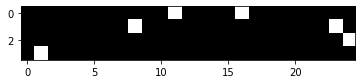

In [ ]:

plt.imshow(image_list[2], cmap='gray')

In [ ]:
#Shuffle the dataset
img_array = [list(tf.keras.preprocessing.image.img_to_array(img)) for img in image_list]

onehot_label = keras.utils.to_categorical(y, 2)

img_ds = tf.data.Dataset.from_tensor_slices(img_array)
label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)
print("label_ds: ", label_ds)
print("img_ds: ", img_ds)

# combine img_ds with its corresponding label
full_ds = tf.data.Dataset.zip((img_ds, label_ds))
print(full_ds)

# shuffle
shuffle_buffer = 20
full_ds = full_ds.shuffle(shuffle_buffer, reshuffle_each_iteration=False)

print("full_ds: ", full_ds)

label_ds:  <TensorSliceDataset element_spec=TensorSpec(shape=(2,), dtype=tf.float32, name=None)>
img_ds:  <TensorSliceDataset element_spec=TensorSpec(shape=(4, 25, 1), dtype=tf.float32, name=None)>
<ZipDataset element_spec=(TensorSpec(shape=(4, 25, 1), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>
full_ds:  <ShuffleDataset element_spec=(TensorSpec(shape=(4, 25, 1), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>


In [ ]:
# train & test data
total_len = len(dataset)
train_len = int(0.8*total_len)
test_len = total_len - train_len
train_ds = full_ds.take(train_len)
test_ds = full_ds.take(test_len)

# train & validation data
train_total_len = train_len
train_len = int(0.8 * train_total_len)
val_len = train_total_len - train_len

val_ds = train_ds.skip(val_len)
train_ds = train_ds.take(train_len)

# batch
batch_size = 50
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

print("total dataset is ", total_len)
print("total training datatset is ", train_len)
print("total test set is of length ", test_len)

total dataset is  1021
total training datatset is  652
total test set is of length  205


In [ ]:
trainiter = iter(train_ds)
x, y = trainiter.next()

print("training image batch shape: ", x.shape)
print("training label batch shape", y.shape)

training image batch shape:  (50, 4, 25, 1)
training label batch shape (50, 2)


# CNN-1

In [ ]:


full_ds_iter = iter(full_ds)
x, y = full_ds_iter.next()

print("input shape: ", x.shape)
print("label shape: ", y.shape)


input_shape=  x.shape #(4, 25, 1)
num_classes = y.shape[0] 

model = keras.Sequential(
    [
    keras.Input(shape=input_shape),
     
    layers.Conv2D(32, kernel_size = (3,3), activation = "relu", padding = "same"),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    
    layers.Dropout(0.5), 
    
    layers.Flatten(),
    
    
    layers.Dense(512, activation = "relu"),
    
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = "softmax"),
    ]
)
print("\n")
model.summary()

input shape:  (4, 25, 1)
label shape:  (2,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 25, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 23, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 11, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 11, 64)         0         
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 512)               360960    
          

In [ ]:
epochs = 100

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# early stopping -> determines the threshold to stop training, even if the dataset is not fully trained
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=15, mode = 'max')

start = time.time()
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks=[earlystop_callback])

print("Total training time:", time.time() - start)

# save 
dump(model, "/content/drive/MyDrive/MalwareDataset/Model/CNN/model1.joblib")

Epoch 1/100
14/14 [==============================] - 2s 43ms/step - loss: 0.6024 - accuracy: 0.6948 - val_loss: 0.4491 - val_accuracy: 0.8282
Epoch 2/100
14/14 [==============================] - 0s 28ms/step - loss: 0.4130 - accuracy: 0.8344 - val_loss: 0.3287 - val_accuracy: 0.8712
Epoch 3/100
14/14 [==============================] - 0s 30ms/step - loss: 0.3444 - accuracy: 0.8604 - val_loss: 0.2817 - val_accuracy: 0.8957
Epoch 4/100
14/14 [==============================] - 0s 25ms/step - loss: 0.3109 - accuracy: 0.8712 - val_loss: 0.2558 - val_accuracy: 0.9049
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 0.2765 - accuracy: 0.8942 - val_loss: 0.2359 - val_accuracy: 0.9049
Epoch 6/100
14/14 [==============================] - 0s 24ms/step - loss: 0.2628 - accuracy: 0.9034 - val_loss: 0.2216 - val_accuracy: 0.9126
Epoch 7/100
14/14 [==============================] - 0s 25ms/step - loss: 0.2387 - accuracy: 0.9034 - val_loss: 0.2073 - val_accuracy: 0.9279
Epoch 

['/content/drive/MyDrive/MalwareDataset/Model/CNN/model1.joblib']

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


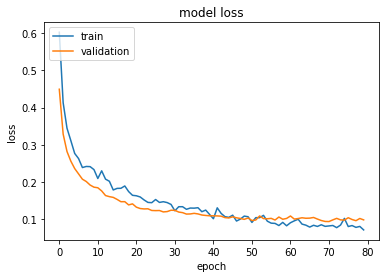

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
_test_ds = test_ds.batch(batch_size)

# load model
model1 = load("/content/drive/MyDrive/MalwareDataset/Model/CNN/model1.joblib")
loss, accuracy = model1.evaluate(_test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# get label from batchdataset
arr_test_ds = np.array(list(_test_ds)) # convert batchdataset to array
arr_test_label = arr_test_ds[:,1]
#print(d)

y_test = tf.concat([x for x in arr_test_label], 0) # concate value in every batch

# get predict label
y_predict = model1.predict(_test_ds, batch_size=batch_size)

# convert scale to 0 1, eg: if 0.001(benign) and 0.999(malware) -> 1
y_test = np.argmax(y_test, axis=1)
y_predict = np.argmax(y_predict, axis=1)

print(metrics.classification_report(y_test, y_predict))

5/5 [==============================] - 0s 7ms/step - loss: 0.0668 - accuracy: 0.9707
Test loss: 0.0668453574180603
Test accuracy: 0.9707317352294922
5/5 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       0.97      0.95      0.96        80

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


# CNN -2

In [ ]:


full_ds_iter = iter(full_ds)
input, label = full_ds_iter.next()

input_shape = input.shape
num_classes = label.shape[0]

model2 = keras.Sequential(
    [
     keras.Input(shape=input_shape),
     
     layers.Conv2D(32, kernel_size=(3,3), activation="relu", padding="same"),
     layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
     layers.MaxPooling2D(pool_size=(2,2)),

     layers.Dropout(0.5),
     layers.Flatten(),
     layers.Dense(512, activation="relu"),
     layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(64, activation="relu"),

     layers.Dropout(0.5),
     layers.Dense(num_classes, "softmax")
    ]
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 4, 25, 32)         320       
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 23, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 11, 64)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 11, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 704)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               360960    
                                                      

In [ ]:
epochs = 100

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

earlystop_callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.0001, patience=15, mode="max")

start = time.time()
history2 = model2.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[earlystop_callback])

print("Total training time:", time.time() - start)

# save model
dump(model2, "/content/drive/MyDrive/MalwareDataset/Model/CNN/model2.joblib")

Epoch 1/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6394 - accuracy: 0.6549 - val_loss: 0.4491 - val_accuracy: 0.8067
Epoch 2/100
14/14 [==============================] - 0s 31ms/step - loss: 0.4057 - accuracy: 0.8267 - val_loss: 0.2899 - val_accuracy: 0.8926
Epoch 3/100
14/14 [==============================] - 0s 29ms/step - loss: 0.3174 - accuracy: 0.8712 - val_loss: 0.2483 - val_accuracy: 0.8988
Epoch 4/100
14/14 [==============================] - 0s 28ms/step - loss: 0.3024 - accuracy: 0.8727 - val_loss: 0.2188 - val_accuracy: 0.9156
Epoch 5/100
14/14 [==============================] - 0s 31ms/step - loss: 0.2633 - accuracy: 0.9018 - val_loss: 0.1974 - val_accuracy: 0.9294
Epoch 6/100
14/14 [==============================] - 0s 27ms/step - loss: 0.2649 - accuracy: 0.8942 - val_loss: 0.1839 - val_accuracy: 0.9310
Epoch 7/100
14/14 [==============================] - 0s 28ms/step - loss: 0.2189 - accuracy: 0.9126 - val_loss: 0.2096 - val_accuracy: 0.9187
Epoch 

['/content/drive/MyDrive/MalwareDataset/Model/CNN/model2.joblib']

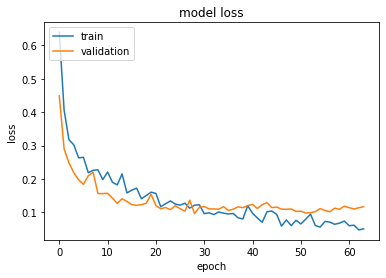

In [ ]:

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
_test_ds = test_ds.batch(batch_size)

# load model
model2 = load("/content/drive/MyDrive/MalwareDataset/Model/CNN/model2.joblib")
loss, accuracy = model2.evaluate(_test_ds)

print("loss: ", loss)
print("accuracy: ", accuracy)

# get label in _test_ds
arr_test_ds = np.array(list(_test_ds))
arr_test_label = arr_test_ds[:,1]

y_test = tf.concat([x for x in arr_test_label], axis=0)
#print(y_test)

y_predict = model2.predict(_test_ds, batch_size=batch_size)

# convert scale to 0 1
y_test = np.argmax(y_test, axis=1)
y_predict = np.argmax(y_predict, axis=1)

print(metrics.classification_report(y_test, y_predict))

5/5 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.9805
loss:  0.05459645763039589
accuracy:  0.9804878234863281
5/5 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       125
           1       0.97      0.97      0.97        80

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()
